In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

2022-10-07 12:34:21.859317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 12:34:26.192025: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 12:34:31.929266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-07 12:34:31.929400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [4]:
#hyperparameters and blank image and label generation
N = 4000
size = 64
big_blob_size = 8
big_blob_range = 2
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [13]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_new_blob_img(ellipse=True, size=size,num_big_blobs=1)
    elif labels[i] == 1:
        x = generator.generate_new_blob_img(ellipse = False, size = size, num_big_blobs=1)
    imgs[:,:,i] = x

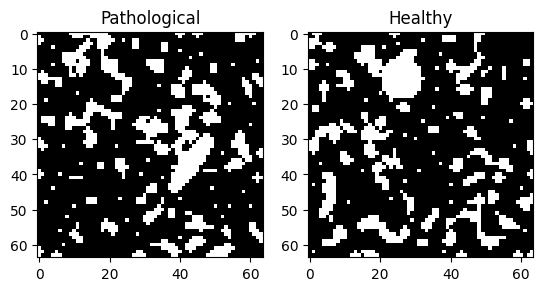

In [15]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");

In [16]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(4000, 64, 64, 1)

In [18]:
# Model hyperparameters
num_classes = 2
input_shape = (size, size, 1)
batch_size = 64
epochs = 40
conv_size=(3,3)
save = True
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [20]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_3 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                      

In [21]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/40
38/38 [==============================] - 11s 273ms/step - loss: 2.0309 - accuracy: 0.5029 - val_loss: 0.6971 - val_accuracy: 0.4851
Epoch 2/40
38/38 [==============================] - 10s 254ms/step - loss: 1.3117 - accuracy: 0.6028 - val_loss: 0.7006 - val_accuracy: 0.5261
Epoch 3/40
38/38 [==============================] - 10s 249ms/step - loss: 1.0615 - accuracy: 0.6596 - val_loss: 0.7101 - val_accuracy: 0.4664
Epoch 4/40
38/38 [==============================] - 10s 268ms/step - loss: 0.9339 - accuracy: 0.6944 - val_loss: 0.7627 - val_accuracy: 0.5522
Epoch 5/40
38/38 [==============================] - 11s 282ms/step - loss: 0.7473 - accuracy: 0.7367 - val_loss: 0.9952 - val_accuracy: 0.5373
Epoch 6/40
38/38 [==============================] - 11s 286ms/step - loss: 0.6208 - accuracy: 0.7794 - val_loss: 0.7934 - val_accuracy: 0.5448
Epoch 7/40
38/38 [==============================] - 11s 290ms/step - loss: 0.4997 - accuracy: 0.8209 - val_loss: 0.7724 - val_accuracy: 0.5560

In [24]:
if save:
    model.save("models/model40_big_e_vs_c")

INFO:tensorflow:Assets written to: models/model40_big_e_vs_c/assets


INFO:tensorflow:Assets written to: models/model40_big_e_vs_c/assets


In [ ]:
model = tf.keras.models.load_model("models/model30_circle_ellipse/")

In [22]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.057677529752254486
Test accuracy: 0.9833333492279053
42/42 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

Pathological       1.00      0.97      0.98       644
     Healthy       0.97      1.00      0.98       676

    accuracy                           0.98      1320
   macro avg       0.98      0.98      0.98      1320
weighted avg       0.98      0.98      0.98      1320



In [23]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


42/42 [==============================] - 1s 23ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

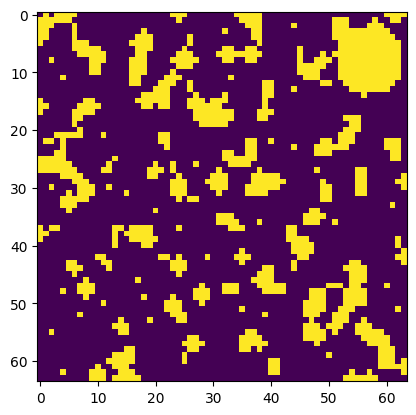

In [36]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][0]]
plt.imshow(img)

In [26]:
#choose explainability options
explain_picker = widgets.SelectMultiple(
    options=['GradCAM', 'Single Blob Occlusion', 'Patch Occlusion', 'Overlapping Patch Occlusion'],
    value=['GradCAM'],
    #rows=10,
    description='Methods',
    disabled=False
)

display(explain_picker)

SelectMultiple(description='Methods', index=(0,), options=('GradCAM', 'Single Blob Occlusion', 'Patch Occlusio…

In [37]:
%%capture
heatmaps = []

for method in explain_picker.value:
    if method == 'GradCAM':
        heatmaps.append(explainabilityModels.make_gradcam_heatmap(img, model, -5))
    elif method == 'Single Blob Occlusion':
        heatmaps.append(explainabilityModels.single_blob_occlusion(img, label_picker.value, model=model)[0])
    elif method == 'Patch Occlusion':
        heatmaps.append(explainabilityModels.occlusion_map(img, label_picker.value, patch_size = 8, model=model))
    elif method == 'Overlapping Patch Occlusion':
        heatmaps.append(explainabilityModels.overlapping_occlusion_map(img, label_picker.value, patch_size=8, step_size = 2, model=model))
        

0


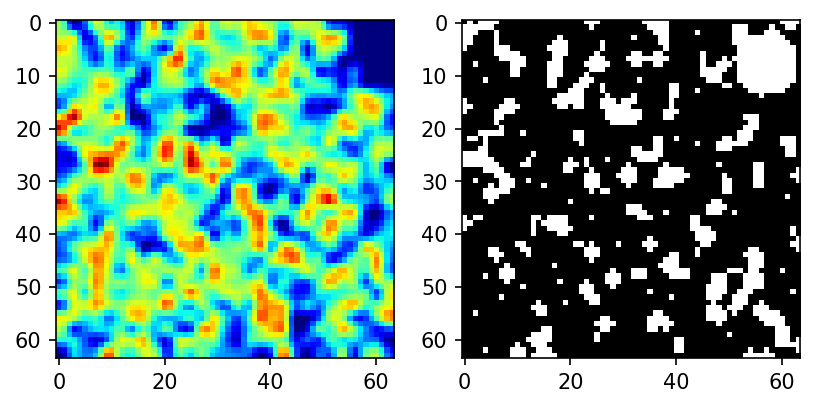

In [38]:
fig, ax = plt.subplots(1, len(heatmaps)+1)
fig.set_dpi(150)
fig.tight_layout
for idx, map in enumerate(heatmaps):
    print(idx)
    ax[idx].imshow(map, cmap=plt.cm.jet)

ax[-1].imshow(img, cmap=plt.cm.gray)